# Handwritten Recognition

## Imports

In [1]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from PIL import Image

import matplotlib.pyplot as plt
import seaborn_image as isns

import tensorflow as tf
import numpy as np
import os

import cv2
from imutils import contours
import numpy as np

## Settings

In [2]:
# Set random seed for testing
np.random.seed(3)
tf.random.set_seed(3)

In [3]:
# Image preprocessing settings
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

## Functions

In [4]:
def get_image_path_lable(path_lst):
    """Get image path and label"""
    paths = []
    labels = []
    # For every line in the path list
    for (i, file_line) in enumerate(path_lst):
        # Split the lines
        line_split = file_line.strip() # Remove \n 
        line_split = line_split.split() # Split the "sentence"
        
        image_name = line_split[0] # Get first "word"
        part_1 = image_name.split("-")[0] # Get first part of image path
        part_2 = image_name.split("-")[1] # Get second part of image path
        # Add it together
        img_path = os.path.join(f"{path}\\words\\{part_1}\\{part_1}-{part_2}\\{image_name}.png")
        
        # If file exists add it to the path and lables lists 
        if os.path.getsize(img_path):
            paths.append(img_path)
            labels.append(line_split[-1]) # Last word in line_split is the label
    
    # Return the lists
    return paths, labels

In [5]:
def resize_image(image, img_size):
    """Resize image without distortion (add padding)"""
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)
    
    # Check the amont of padding needed to be done
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]
    
    # Get same amount of padding on both sides
    # Top and Bottom
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2
    # Left and Right
    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2
    # Add padding
    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],
                                    [pad_width_left, pad_width_right],
                                    [0,0]])
    
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    
    return image

In [6]:
def preprocessing_image(image_path, image_size=(image_width, image_height)):
    """Prepare image for the model"""
    # Read file
    image = tf.io.read_file(image_path)
    # Decode a PNG-encoded image to a uint8 tensor
    image = tf.image.decode_png(image, 1)
    # Resize the image
    image = resize_image(image, image_size)
    # Change dtype to float32
    image = tf.cast(image, tf.float32) / 255.0
    
    return image

In [7]:
def preprocessing_label(label):
    """Prepare label for the model"""
    # Splits each string into a sequence of Unicode code points.
    # And mapps characters to number
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # Get the length of the label
    length = tf.shape(label)[0]
    # How much padding is added (longest label length - current label lenght)
    pad_amount = max_len - length
    # Add padding
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    
    return label

In [8]:
def join_image_label(image_path, label):
    """Apply preprocessing functions"""
    # Apply preprocessing to image
    image = preprocessing_image(image_path)
    # Apply preprocessing to label
    label = preprocessing_label(label)
    # Return a dictionary
    return {"image": image, "label": label}

In [9]:
def prepare_data(image_paths, lables):
    """Create DF"""
    # Creates a `Dataset` whose elements are slices of the given tensors
    df = tf.data.Dataset.from_tensor_slices((image_paths, lables)).map(
                                                        join_image_label, num_parallel_calls=auto_tune)
    return df.batch(batch_size).cache().prefetch(auto_tune)

In [10]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

## Data

### Read

In [11]:
# Path to Word data
path = os.getcwd()

In [12]:
# Word image path list
words_list = []

# Open Word.txt (contains list of file path tom word images)
words = open(f"{path}\\words\\words.txt", "r").readlines()
# Split text in to lines and add to list 
for line in words:
    if line[0] == "#": # Skip if line starts with #
        continue
    if line.split(" ")[1] != "err":  # Skip errors
        words_list.append(line) # Add file path to list

# Shuffle the list 
np.random.shuffle(words_list)

### Split

In [13]:
# Split in to train(80%), test(10%), validation(10%)
# Train
split_train = int(0.8 * len(words_list))
train = words_list[:(split_train)]
# Test & Val
test_val = words_list[split_train:]
split_val = int(0.5 * len(test_val))
test = test_val[:split_val]
val = test_val[split_val:]

# Give error if length of train, test and val not equal to length word_list
assert len(words_list) == len(train) + len(val) + len(test), (
                                    "len of train, val, test not equal to len of word list")

### Paths and Labels

In [14]:
# Create list of path and lables
train_img_paths, train_labels = get_image_path_lable(train)
val_img_paths, val_labels = get_image_path_lable(val)
test_img_paths, test_labels = get_image_path_lable(test)

In [15]:
# Create characters set (Get all unique characters and symbols)
char_set = set()
max_len = 0
for word in train_labels:
    # Get the number of characters in the longest word
    max_len = max(max_len, len(word))
    for char in word:
        char_set.add(char)

with open('char_set.txt', 'w') as f:
    for line in char_set:
        f.write(line)
        f.write('\n')

### Preprocessing 

In [16]:
# data.AUTOTUNE, will prompt the tf.data runtime to tune the value dynamically at runtime. 
auto_tune = tf.data.AUTOTUNE

# Mapping characters to number
char_to_num = StringLookup(vocabulary=list(char_set), mask_token=None)

# Mapping number to characters
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [18]:
# train Dataset
train_ds = prepare_data(train_img_paths, train_labels)
val_ds = prepare_data(val_img_paths, val_labels)
test_ds = prepare_data(test_img_paths, test_labels)

## The Model
https://distill.pub/2017/ctc/

In [19]:
class CTC_Layer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

### Build Model

In [20]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    X = keras.layers.Conv2D(32,
                            (3, 3),
                            activation="relu",
                            kernel_initializer="he_normal",
                            padding="same",
                            name="Conv1",
                           )(input_img)
    
    X = keras.layers.MaxPooling2D((2, 2), name="pool1")(X)

    # Second conv block.
    X = keras.layers.Conv2D(64,
                            (3, 3),
                            activation="relu",
                            kernel_initializer="he_normal",
                            padding="same",
                            name="Conv2",
    )(X)
    
    X = keras.layers.MaxPooling2D((2, 2), name="pool2")(X)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    X = keras.layers.Reshape(target_shape=new_shape, name="reshape")(X)
    X = keras.layers.Dense(64, activation="relu", name="dense1")(X)
    X = keras.layers.Dropout(0.2)(X)

    # RNNs.
    X = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(X)
    
    X = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(X)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    X = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(X)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTC_Layer(name="ctc_loss")(labels, X)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ML_Handwriting_Recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()

Model: "ML_Handwriting_Recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0

## Evaluation Metric

In [21]:
val_images = []
val_labels = []

for i in val_ds:
    val_images.append(i["image"])
    val_labels.append(i["label"])

In [22]:
def calculate_edit_dist(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

In [23]:
class edit_distance_callback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model  = pred_model
        
    def on_epoch_end(self, epoch, logs=None):
        edit_dist = []
        
        for i in range(len(val_images)):
            labels = val_labels[i]
            pred = self.prediction_model.predict(val_images[i])
            edit_dist.append(calculate_edit_dist(labels, pred).numpy())
            
        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_dist):.4f}")

## Training

In [55]:
# Num of "loops"
epochs = 100 # Only did 10 for the testing. Lost my full version and didn't have time to re create it
# Stop if loss doesn't improve during 3 "loops"
early_stopping_patience = 3
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True)

# The model
model = build_model()
pred_model = keras.models.Model(
                        model.get_layer(name="image").input, 
                        model.get_layer(name="dense2").output)

edit_dist_callback = edit_distance_callback(pred_model)

# Train the model
model.fit(train_ds,
          validation_data=val_ds,
          epochs=epochs,
          use_multiprocessing=True,
          callbacks=[early_stopping])

#model.save("saved_model\\model_v_4")

Epoch 1/10
1206/1206 [==============================] - 296s 240ms/step - loss: 13.7394 - val_loss: 12.1934
Epoch 2/10
1206/1206 [==============================] - 441s 366ms/step - loss: 11.3183 - val_loss: 10.1680
Epoch 3/10
1206/1206 [==============================] - 328s 272ms/step - loss: 9.6277 - val_loss: 8.7249
Epoch 4/10
1206/1206 [==============================] - 323s 268ms/step - loss: 8.1639 - val_loss: 7.1026
Epoch 5/10
1206/1206 [==============================] - 324s 268ms/step - loss: 6.8709 - val_loss: 5.7851
Epoch 6/10
1206/1206 [==============================] - 321s 266ms/step - loss: 5.9648 - val_loss: 4.9832
Epoch 7/10
1206/1206 [==============================] - 315s 261ms/step - loss: 5.2875 - val_loss: 4.3382
Epoch 8/10
1206/1206 [==============================] - 319s 265ms/step - loss: 4.7479 - val_loss: 3.8892
Epoch 9/10
1206/1206 [==============================] - 319s 264ms/step - loss: 4.3157 - val_loss: 3.5197
Epoch 10/10
1206/1206 [===================

In [58]:
model.summary()

Model: "ML_Handwriting_Recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0

## EVALUATE

### Prepare image

In [33]:
eval_path = path = os.getcwd()

In [34]:
# Convert jpeg to png
convert_list = list(map(str.strip,open(f"{eval_path}\\jpg\\convert_list.txt", "r").readlines()))
for i in convert_list:
    Image.open(f'{eval_path}\\jpg\\{i}.jpg').save(f'{eval_path}{i}.png')

#### Change brightness (if needed)

In [59]:
orginal = cv2.imread(f'{eval_path}\\img.png')

alpha = 1 # Contrast control (1= No change, < 0 lower, > 1 higer)
beta = 1 # Brightness control (1= No change, < 0 lower, > 1 higer)
adjusted = cv2.convertScaleAbs(orginal, alpha=alpha, beta=beta)

# Preview changes
cv2.imshow('original', orginal)
cv2.imshow('adjusted', adjusted)
cv2.waitKey()

# Save changes
cv2.imwrite(f'{eval_path}image.png', adjusted)

True

#### Split image into images of words
This need some work! <br>
Words are not in correct order. Splitting into lines before splitting into words could solve this problem

In [60]:
# Load image of text
image = cv2.imread(f'{eval_path}image.png')
# change in to Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Add blur
blur = cv2.GaussianBlur(gray, (1,1), 0)
# Add threshold
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

# Dilate to combine adjacent text contours
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,10))
dilate = cv2.dilate(thresh, kernel, iterations=4)

# Find contours, highlight text areas, and extract words
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Saved image number 
img_number = 0
# Clear image list text file
open(f'{eval_path}\\img_list.txt', 'w').close()
# Loop and save every word as an image
for c in sorted_ctrs:
    area = cv2.contourArea(c)
    if area > 1000:
        x,y,w,h = cv2.boundingRect(c)
        img = image[y:y+h, x:x+w]
        cv2.imwrite(eval_path+'img_{}.png'.format(img_number), img)
        cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
        # Write to image name to list text file
        with open(f'{eval_path}img_list.txt', 'a') as f:
            f.write(f'img_{img_number}\n')
        # Change the image number
        img_number += 1
        

## Prediction

2/2 [==============================] - 0s 45ms/step


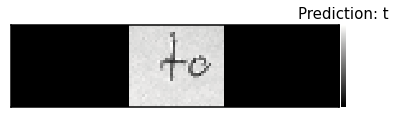

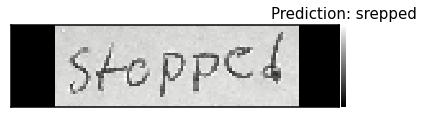

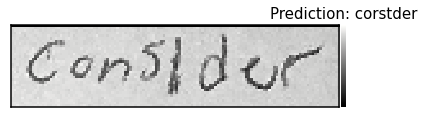

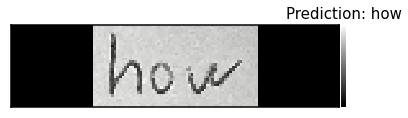

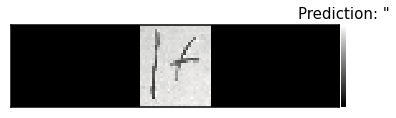

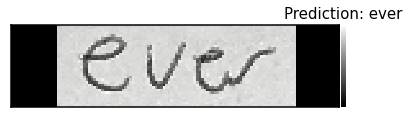

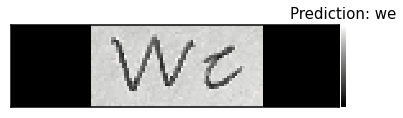

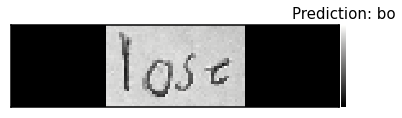

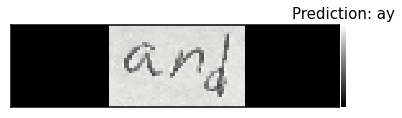

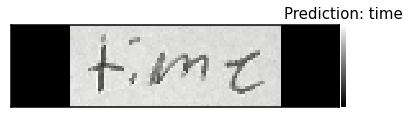

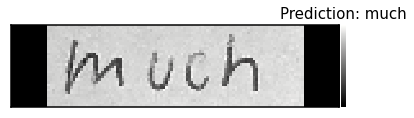

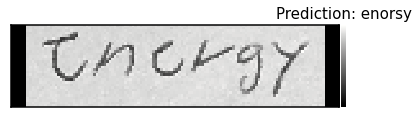

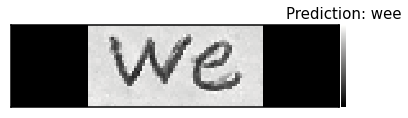

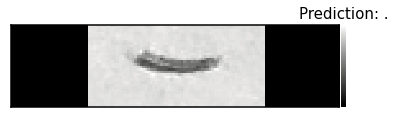

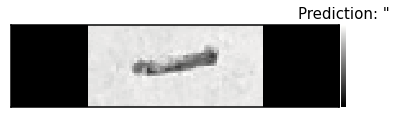

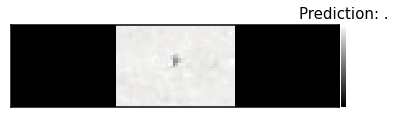

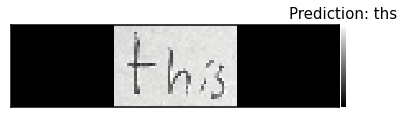

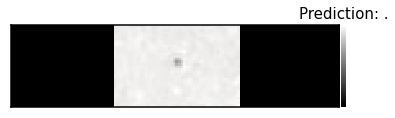

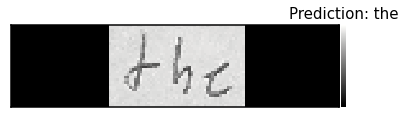

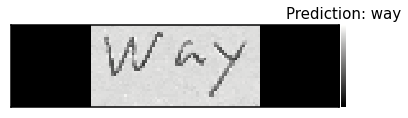

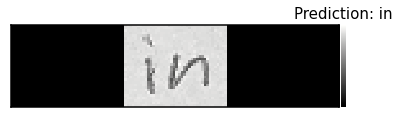

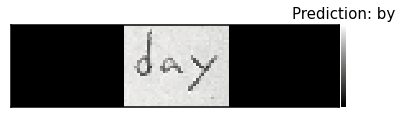

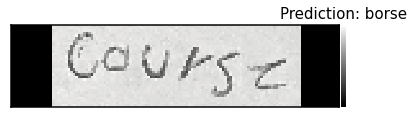

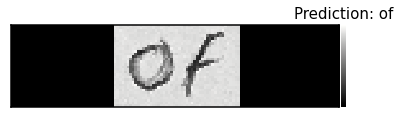

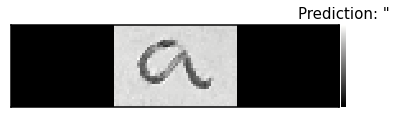

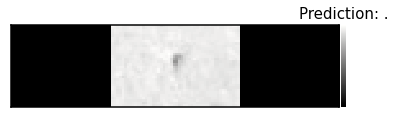

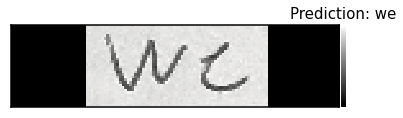

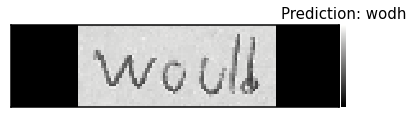

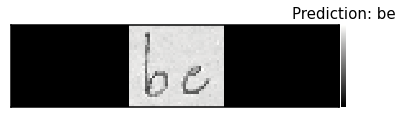

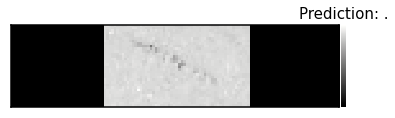

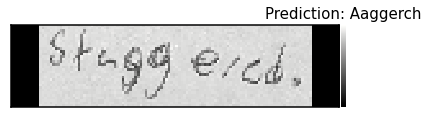

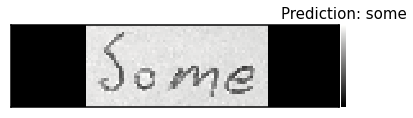

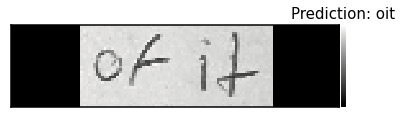

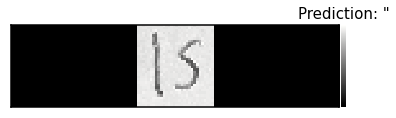

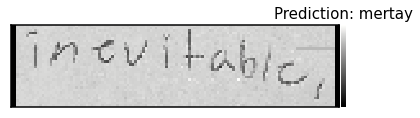

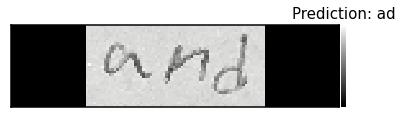

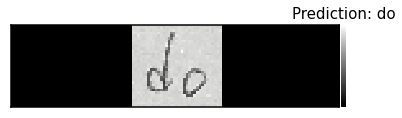

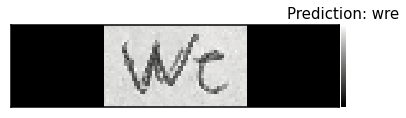

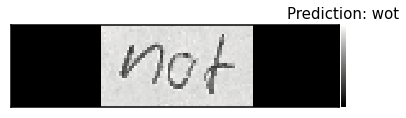

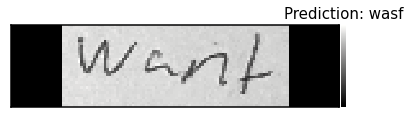

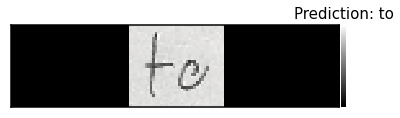

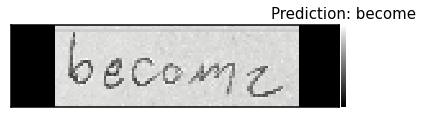

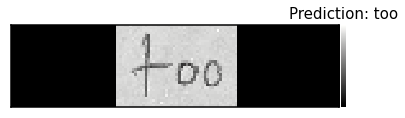

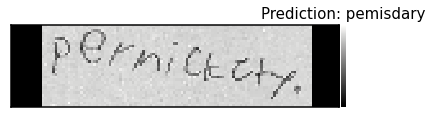

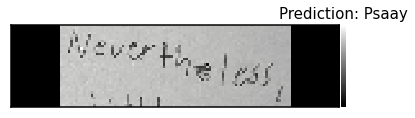

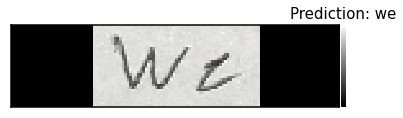

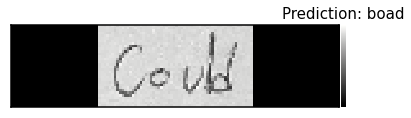

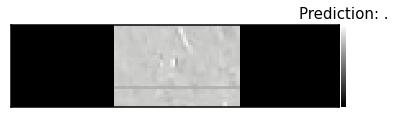

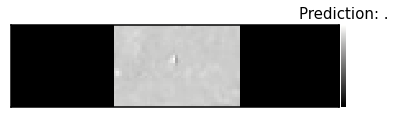

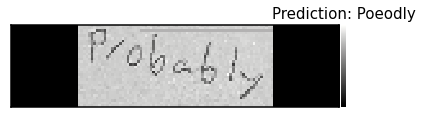

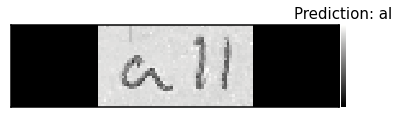

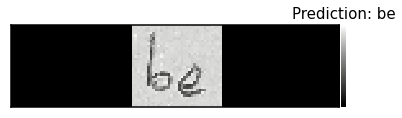

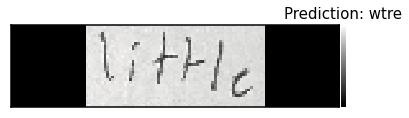

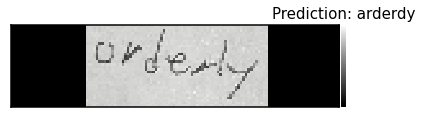

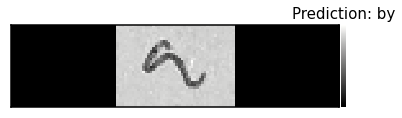

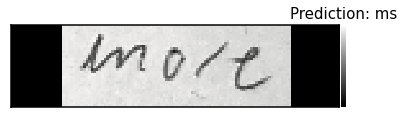

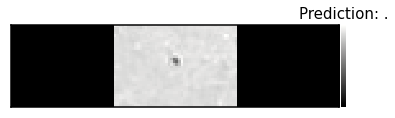

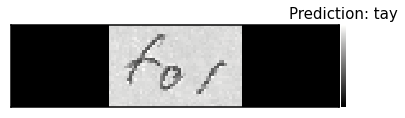

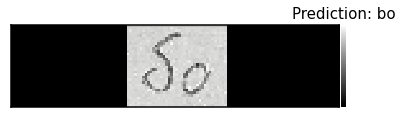

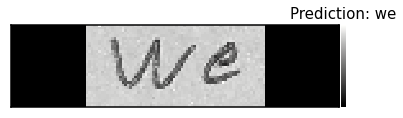

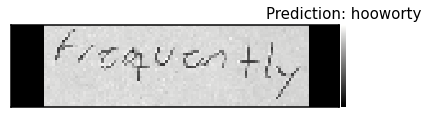

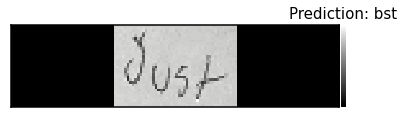

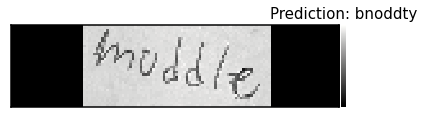

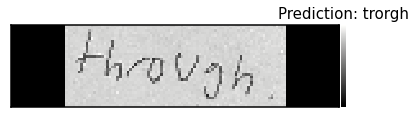

In [61]:
eval_labels = list(map(str.strip,open(f"{eval_path}img_list.txt", "r").readlines()))
eval_img_paths = [f"{eval_path}{i}.png" for i in eval_labels]

eval_ds = prepare_data(eval_img_paths, eval_labels)
eval_pred = decode_batch_predictions(pred_model.predict(eval_ds))

open(f'{eval_path}Prediction.txt', 'w').close()

for batch in eval_ds.take(1):
    batch_images = batch["image"]
    preds = pred_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

for i in range(len(batch_images)):
    img = batch_images[i]
    img = tf.transpose(img, perm=[1, 0, 2])
    img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]
     
    # Write Prediction to a text file
    with open(f'{eval_path}Prediction.txt', 'a') as f:
        f.write(f'{pred_texts[i]} ')
    title = f"Prediction: {pred_texts[i]}"
    isns.imgplot(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.show()